In [1]:
import itertools
import subprocess

import numpy as np

import ad3

In [2]:
# Graph vizualizer with dot
# inspired by NLTK (License: Apache 2.0, Copyright (C) 2001-2016 NLTK Project), but slightly more general.

class DepGraph(object):
    def __init__(self, labels, links):
        self.labels = labels
        self.links = links

    def _repr_svg_(self):
        # Start the digraph specification
        head = """\
digraph G{
edge [dir=forward]
node [shape=plaintext]"""

        lbl_code = ['{} [label="{}"]'.format(k, w)
                    for k, w in enumerate(self.labels)]

        link_code = ['{} -> {}'.format(*link) for link in self.links]

        dot_string = "\n".join([head] + lbl_code + link_code + ["}"])
        
        try:
            process = subprocess.Popen(
                ['dot', '-Tsvg'],
                shell=True,
                stdin=subprocess.PIPE,
                stdout=subprocess.PIPE,
                stderr=subprocess.PIPE,
                universal_newlines=True,
            )
        except OSError:
            raise Exception('Cannot find the dot binary from Graphviz package')
        out, err = process.communicate(dot_string)
        if err:
            raise Exception(
                'Cannot create svg representation by running dot from string: {}'
                'because: {}'.format(dot_string, err))
        
        return out

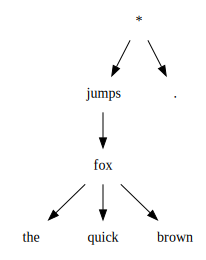

In [3]:
DepGraph("* the quick brown fox jumps .".split(),
         [(4, 1), (4, 2), (4, 3), (5, 4), (0, 5), (0, 6)])
         

Parse sentence using random potentials, but no tree constraints

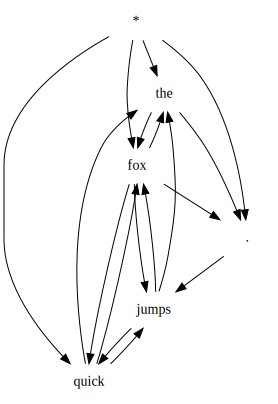

In [4]:
rng = np.random.RandomState(0)

sentence = ["*", "the", "quick", "fox", "jumps", "."]

# possible edge from every node to every other node OR the root
link_ix = []
link_var = []

fg = ad3.PFactorGraph()
for mod in range(1, len(sentence)):
    for head in range(len(sentence)):
        if mod == head:
            continue

        link_ix.append((head, mod))
        var = fg.create_binary_variable()
        var.set_log_potential(rng.uniform(-1, 1))
        
        link_var.append(var)

fg.set_eta_ad3(.1)
fg.adapt_eta_ad3(True)
fg.set_max_iterations_ad3(1000)
value, marginals, edge_marginals, value = fg.solve_lp_map_ad3()

pred_links = [link for link, posterior in zip(link_ix, marginals)
              if posterior > 0.1]

DepGraph(sentence, pred_links)

Same model, this time WITH tree constraints

integral


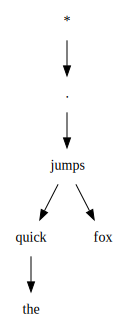

In [5]:
tree_f = ad3.extensions.PFactorTree()
fg.declare_factor(tree_f, link_var)
tree_f.initialize(len(sentence), link_ix)

value, marginals, edge_marginals, status = fg.solve()

print(status)

pred_links = [link for link, posterior in zip(link_ix, marginals)
              if posterior > 0.1]

DepGraph(sentence, pred_links)